# APS1070
#### Anomaly Detection - Project 2



Project 2 has two parts: a tutorial component (which will be covered in labs) and an exercises component (to be completed as homework, individually). Overall, this project is worth 12.5% of your final grade. Completing the tutorial section is worth 2.5 marks. The exercises section will be graded out of the remaining 10 marks.


Please fill out the following:


*   Your **name**: Tianyi Yu
*   Your **student number**: 1005898502



## Tutorial

In this part of the assignment, we will implement an anomaly detection algorithm using the Gaussian model to detect anomalous behavior in a 2D dataset first and then a high-dimensional dataset.

Loading relevant libraries and the dataset

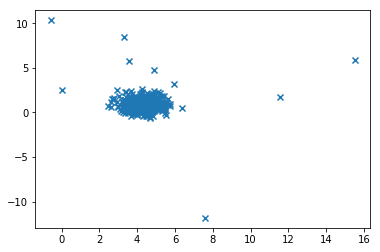

In [57]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=1,
                       cluster_std=0.60, random_state=0)
X_append, y_true_append = make_blobs(n_samples=10,centers=1,
                                    cluster_std=5,random_state=0)
X = np.vstack([X,X_append])
y_true = np.hstack([y_true, [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting
plt.scatter(X[:,0],X[:,1],marker="x");

Here we've manufactured a dataset where some points are visibly outliers from the main distribution.

We can see this from looking at the plot, but how do we robustly identify the outliers? 

That's where a Gaussian estimation comes in. For this dataset, we only need a single Gaussian, for which we are gonna calculate the mean and standard deviation. Then, we're able to find the points that don't seem likely to have originated from that distribution - these are our outliers!

First, we need to calculate the mean and variance for our data. Complete the function below to generate these values using these formulae:

$$\mu = \frac{1}{m} \sum_{i=1}^{m}X_i$$

$$\sigma^2 = \frac{1}{m} \sum_{i=1}^{m}(X_i-\mu)^2$$

In [0]:
def estimateGaussian(X):
    """
     This function provides an estimate of mean and variance 
     of a Gaussian distribution along multiple dimensions
     using X, an N-dimensional vector
    """
    
    m = X.shape[0]
    
    #compute mean of X
    sum_ = np.sum(X,axis=0)
    mu = 1/m *sum_
    
    # compute variance of X
    var = sum(abs(X - mu)**2)/m
    
    return mu,var
mu, sigma = estimateGaussian(X)

Now, we will calculate for each point in X, the probability of the distribution $N(\mu,\sigma^2)$ generating that point randomly. This has been completed for you, although it is important to understand how the calculation of the PDF works.

In [0]:
def multivariateGaussian(X, mu, sigma):
    """
    This function computes the probability density function of a multivariate gaussian distribution.
    """
    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

Now that we have the probability of each point in the dataset, we can plot these on the original scatterplot:

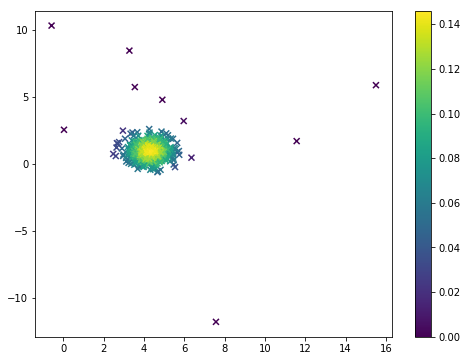

In [60]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
plt.colorbar();

We're getting closer to the point where we can programatically identify our outliers for a single Gaussian distribution. The last step is to identify a value for $p$, below which we consider a point to be an outlier. We term this $\epsilon$.

In [0]:
#Choose a value for epsilon

epsilon = 0.02

Now we'll highlight on the scatter plot all points that are below $\epsilon$:

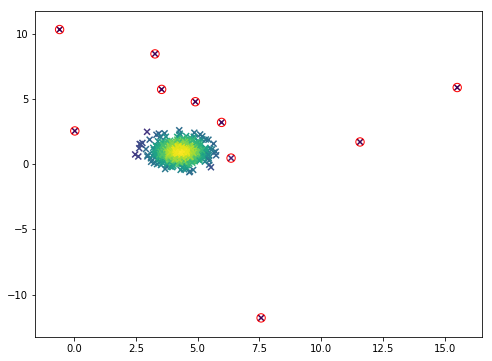

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(X[:,0],X[:,1],marker="x",c=p,cmap='viridis');
# Circling of anomalies
outliers = np.nonzero(p<epsilon)[0]
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);

How well did your epsilon value do? Play around with different values until you're happy with the plot above. 

We can additionally look at our model's classification performance another way. By sorting the points ascending by their probability, and classifying the first $k$ points as anomalous, we can determine the model's precision@k. Implement this in the cell below. 

* What is the highest value of K for which we get precision of 1.0? 10
* What is the precision for K=4? 1.0

In [63]:
from sklearn.metrics import precision_score

for i in range(0,15):
     mn = sorted(p)[i]
     sc = precision_score( y_true,1*(p<=mn))
     print('K is ',i+1, ', precision is', sc)


K is  1 , precision is 1.0
K is  2 , precision is 1.0
K is  3 , precision is 1.0
K is  4 , precision is 1.0
K is  5 , precision is 1.0
K is  6 , precision is 1.0
K is  7 , precision is 1.0
K is  8 , precision is 1.0
K is  9 , precision is 1.0
K is  10 , precision is 1.0
K is  11 , precision is 0.9090909090909091
K is  12 , precision is 0.8333333333333334
K is  13 , precision is 0.7692307692307693
K is  14 , precision is 0.7142857142857143
K is  15 , precision is 0.6666666666666666


You may have noticed that in this example, we are training and testing on the _entire_ dataset. This is absolutely not standard practice! You should _always_ split into a training and testing set. However, the reason that we can get away with this here is because we don't actually use labels at all during training - this is an _unsupervised_ machine learning task. Unsupervised learning methods are beneficial for anomaly detection because in the real world (i.e. testing!) we might come across types of outliers that we didn't see during training. We want to use a method that can handle this, and unsupervised methods are often better suited to this type of domain.

For the next section, we'll move to Mixture of Gaussian models. Take a look at the following dataset:

K is  1 , precision is 1.0
K is  10 , precision is 0.8
K is  100 , precision is 0.14


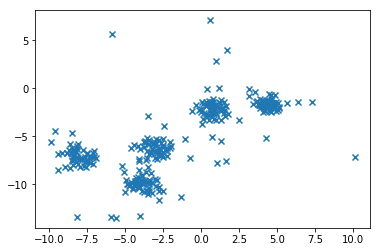

In [64]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
X, y_true = make_blobs(n_samples=400, centers=5,
                       cluster_std=0.60, random_state=1)
X_append, y_true_append = make_blobs(n_samples=50,centers=5,
                                    cluster_std=5,random_state=1)
X = np.vstack([X,X_append])
y_true = np.hstack([[0 for _ in y_true], [1 for _ in y_true_append]])
X = X[:, ::-1] # flip axes for better plotting

X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.33, random_state=1, shuffle=True)

plt.scatter(X_train[:,0],X_train[:,1],marker="x");

def multivariateGaussian(X, mu, sigma):

    k = len(mu)
    
    sigma=np.diag(sigma)
    X = X - mu.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(sigma)**0.5))* np.exp(-0.5* np.sum(X @ np.linalg.pinv(sigma) * X,axis=1))
    return p
p = multivariateGaussian(X, mu, sigma)

kk = [0,9,99]
for i in kk:
     mn = sorted(p)[i]
     sc = precision_score( y_true,1*(p<=mn))
     print('K is ',i+1, ', precision is', sc)

Okay, we have more than one cluster centre now. So what? Let's just ignore that and use the same model as before. 

* What is the precision for k=1 in the cell below? 1.0
* k=10? 0.8
* k=100? 0.14

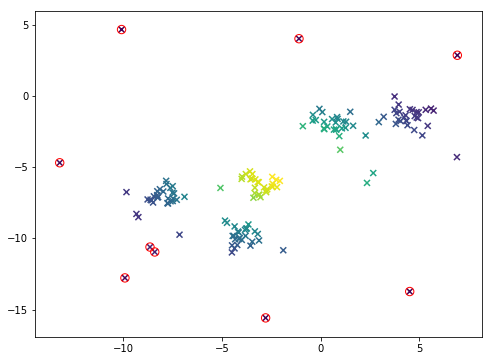

In [65]:
mu, sigma = estimateGaussian(X_train)
p = multivariateGaussian(X_test, mu, sigma)
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0],X_test[:,1],marker="x",c=p,cmap='viridis');
outliers = np.nonzero(p<0.001)[0]
plt.scatter(X_test[outliers,0],X_test[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);



Uh oh. This model performs terribly. It's fit the mean to a section of space where we don't have _any_ points, and it has absolutely no idea which points are outliers! This was probably pretty obvious to you though. We need to move to a Mixture of Gaussians model - one in which we use multiple Gaussians to fit the data. We'll use `sklearn.mixture.GaussianMixture` to do this - or rather you will! Use the documentation, found [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture) to initialise and fit a `GaussianMixture` object called `gm` in the cell below.

In [66]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 5,
                    covariance_type = 'full', random_state=0, )
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Now we can use the method `gm.predict_proba()` to get the probability of each data point being in any of the five clusters:

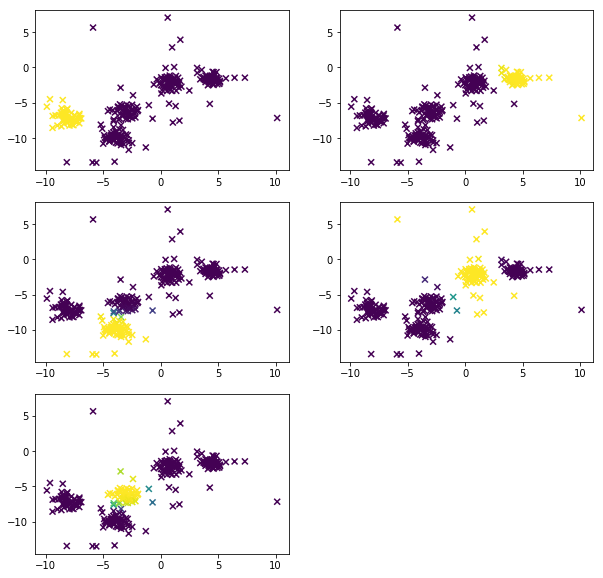

In [67]:
#plt.subplots(3,2,figsize=(8,6))
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(3,2,i+1)
    plt.scatter(X_train[:,0],X_train[:,1],c=gm.predict_proba(X_train)[:,i],cmap='viridis',marker='x')

Our Mixture of Gaussians model is powerful! Not only is it unsupervised, it can both classify points into one of the K clusters we have, _and_ it can help us with our ultimate goal of identifying outlier points! We can do this by finding the points that no cluster wants to claim for itself.

Use the following formula to calculate the probability of each point, and set it to `p`:

$$p(x) = 1 - \bigg( \prod_{i=1}^{k} 1 - p(x \in k) \bigg)$$

This formula returns the probability that the datapoint was produced at random by _any_ of the Gaussians we fit. Hence, we want to filter out anything without a very high probability of this.

In the cell below, calculate these values and then compute precision@k for k=1, 10, and 100.

* Is this model better or worse performing than the previous? **It performs worse than the previous model.**
* Why might that be? **This is caused by the difference between the two functions. Finding the probabilities only tells us which cluster some new point likely belongs to while "score_samples" gives a score based on how likely a point is to have been generated by any cluster.**

For a k of  1  the precision is  1.000  and the recall is  0.056
For a k of  10  the precision is  1.000  and the recall is  0.556
For a k of  100  the precision is  0.180  and the recall is  1.000


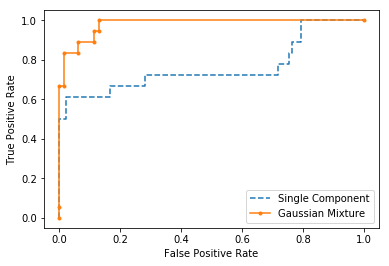

In [68]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

#This part outputs the precision and recall on the test set

p_gm = gm.score_samples(X_test) #score_samples will compute the weighted log probabilities for each sample

for i in [1, 10, 100]: #Let's look at 3 different k values
   mn_gm = sorted(p_gm)[i] #We sort the points by probability, as before
   precision = precision_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using precision
   recall = recall_score(y_test, p_gm < mn_gm) #Here, we compare y_test labels to our picks using recall
   print('For a k of ',i,' the precision is ', '%.3f' % precision,' and the recall is ', '%.3f' % recall) #We print precision and recall three times

#This part computes the ROC curves for both models like we talked about in class

from sklearn.metrics import roc_curve
from matplotlib import pyplot
fpr_sc, tpr_sc, _ = roc_curve(y_test, 1-p)
fpr_gm, tpr_gm, _ = roc_curve(y_test, 1-p_gm)
pyplot.plot(fpr_sc, tpr_sc, linestyle = '--', label='Single Component')
pyplot.plot(fpr_gm, tpr_gm, marker='.', label='Gaussian Mixture')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()



Although our MoG model doesn't perfectly identify all the outliers, it performs way better than our previous model, again without any label information to help it along!

Let's look at a dataset that motivates using a Mixture of Gaussians model: Simpsons ratings.

Everyone knows that there's a certain point when The Simpsons "got bad", but can we use a Mixture of Gaussians to find out exactly when that was?

Load up the `simpsons.pickle` file using the cell below. It contains the IMDb rating for every simpsons episode.

In [69]:
!wget https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
with open('simpsons.pickle','rb') as f:
    simpsons = pickle.load(f)

--2019-10-23 02:11:25--  https://github.com/alexwolson/APS1070_data/raw/master/simpsons.pickle
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle [following]
--2019-10-23 02:11:25--  https://raw.githubusercontent.com/alexwolson/APS1070_data/master/simpsons.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26076 (25K) [application/octet-stream]
Saving to: ‘simpsons.pickle.1’

simpsons.pickle.1   100%[===================>]  25.46K  --.-KB/s    in 0.003s  

2019-10-23 02:11:25 (7.18 MB/s) - ‘simpsons.pickle.1’ saved [26076/26076]



With `plt.hist`, plot a histogram of the rating distribution for all Simpsons episodes. 

* What is the modal rating? The mode is 7.1.
* What is the range of ratings? The range of the rating is from 4.0 to 9.3.

9.3
4.0
7.1


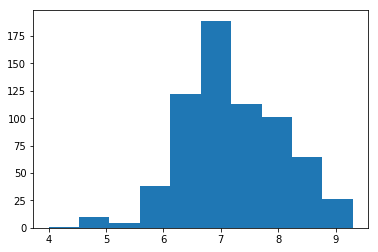

In [70]:
ratings = []
for i in simpsons.values():
  for j in i.values():
    ratings = np.append(ratings,j,axis=None)

plt.hist(ratings)

print(max(ratings))
print(min(ratings))

from statistics import mode
print(mode(ratings))


Next, use `sklearn.mixture.GaussianMixture` to fit a Mixture of Gaussians to the Simpsons rating distribution. Since we are trying to distinguish between good and bad ratings, we only need 2 gaussians.

* What are the means for the two Gaussians fit by the model? 6.77 and 8.18
* What about the standard deviations? 0.60 and 0.47

In [71]:
ratings = np.reshape(ratings, (-1,1))

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 2,
                    covariance_type = 'full',random_state=0,)
gm.fit(ratings)

print(gm.means_)
print(np.sqrt(gm.covariances_))


[[6.7734211 ]
 [8.17942889]]
[[[0.59689303]]

 [[0.4741226 ]]]


Finally, using the `GaussianMixture.predict()` method, we can use maximum likelihood to estimate which distribution, good or bad, each episode belongs to. In the cell below, count the number of episodes predicted to be in the "good" distribution per season, and plot using `plt.plot`.

* Where is the notable drop-off point? Season 10
* When is the first season with 0 good episodes? Season 15

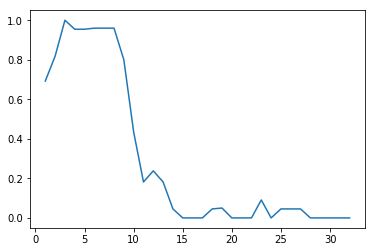

In [72]:
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))

Xs = []
Ys = []
simpsons = dict(sorted(list(simpsons.items()), key=lambda x: x[0]))
for season, episodes in simpsons.items():
     bad = 0
     good = 0
     for episode in episodes.values():
          if gm.predict(np.array(
               episode
          ).reshape(-1,1)) == 0:
               good += 1
          else:
               bad += 1
     Xs.append(season)
     Ys.append(bad/(good+bad))
plt.plot(Xs,Ys);

## Exercises

Now we are going to work with a credit card fraud dataset (more detail can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3)). This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load up the dataset using Pandas' `read_csv` function. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there?[1] **284807**
* What features in the dataset are present aside from the 28 main features?[1] **Time and amount.**
* Why do you think the main features are given to us in this way?[1] **Because the features might contain confidential information about the background.**
* Which column contains the targets? Can you figure out what the values correspond to?[1] **‘Class' contains the targets. Class '1' corresponds to fraud transaction and class '0' corresponds to otherwise transction.**

In [73]:
pip install wget

In [74]:
import wget
wget.download('https://github.com/alexwolson/APS1070_data/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (1).gz'

In [75]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('creditcard.csv')

print(len(df))

print(df.head(10))

print('Class 0 :', df['Class'].value_counts()[0]/len(df)*100, '%')
print('Class 1 :', df['Class'].value_counts()[1]/len(df)*100, '%')

284807
   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0
5   2.0 -0.425966  0.960523  1.141109  ...  0.253844  0.081080    3.67      0
6   4.0  1.229658  0.141004  0.045371  ...  0.034507  0.005168    4.99      0
7   7.0 -0.644269  1.417964  1.074380  ... -1.206921 -1.085339   40.80      0
8   7.0 -0.894286  0.286157 -0.113192  ...  0.011747  0.142404   93.20      0
9   9.0 -0.338262  1.119593  1.044367  ...  0.246219  0.083076    3.68      0

[10 rows x 31 columns]
Class 0 : 99.82725143693798 %
Class 1 : 0.1727485630620034 %


It's always important when looking at a new dataset to figure out how many rows we have for each class.

* What is the percentage of entries in the dataset for each class?[1] **Class 0: 99.83%. Class 1: 0.17%.**
* Why might this pose a problem with methods we have looked at so far?[1] **The two classes do not have even numbers of entries (very unbalanced). In this case, the entries for fraud transactions are not enough for training and testing split while the otherwise transactions would be overfitted.**


Next, split the dataset into a training and testing set using sklearn's `train_test_split` function. Use a test size of one third, and set the random state to 0.

Make sure to separate out the column corresponding to the targets.

As mentioned earlier, in these exercises we are going to use Gaussian distributions to model the data. To accomplish this, we are going to introduce `scipy`, a package which contains a wide variety of tools for working with scientific data in Python. Its `stats` package allows us to easily model various statistical distributions, and get information about them.

Scipy's Gaussian distribution class is called `norm`. It takes two parameters - `loc`, which corresponds to the mean of your distribution, and `scale`, which corresponds to the standard deviation.

* What are the mean and standard deviation for variable V24? Make sure to only use your training set for this.[1] **Mean: 0.00043. Standard deviation: 0.605.**

Use the code below to set up a Gaussian object for V24.

In [77]:
feature_data = df.drop(columns=['Class'])
target_data = df.Class
X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=1/3, random_state=0)


from scipy import stats

norm = stats.norm(loc=X_train['V24'].mean(), scale=X_train['V24'].std()

)

print(X_train['V24'].mean())
print(X_train['V24'].std())

0.00042967016116414686
0.6048294388274841


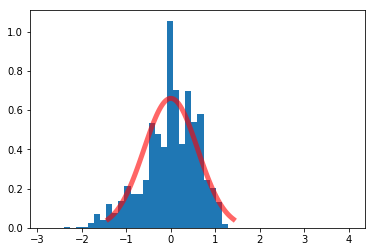

In [78]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.hist(X_train['V24'].values, density=True, histtype='stepfilled', bins=50);
plt.show()

We can also look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

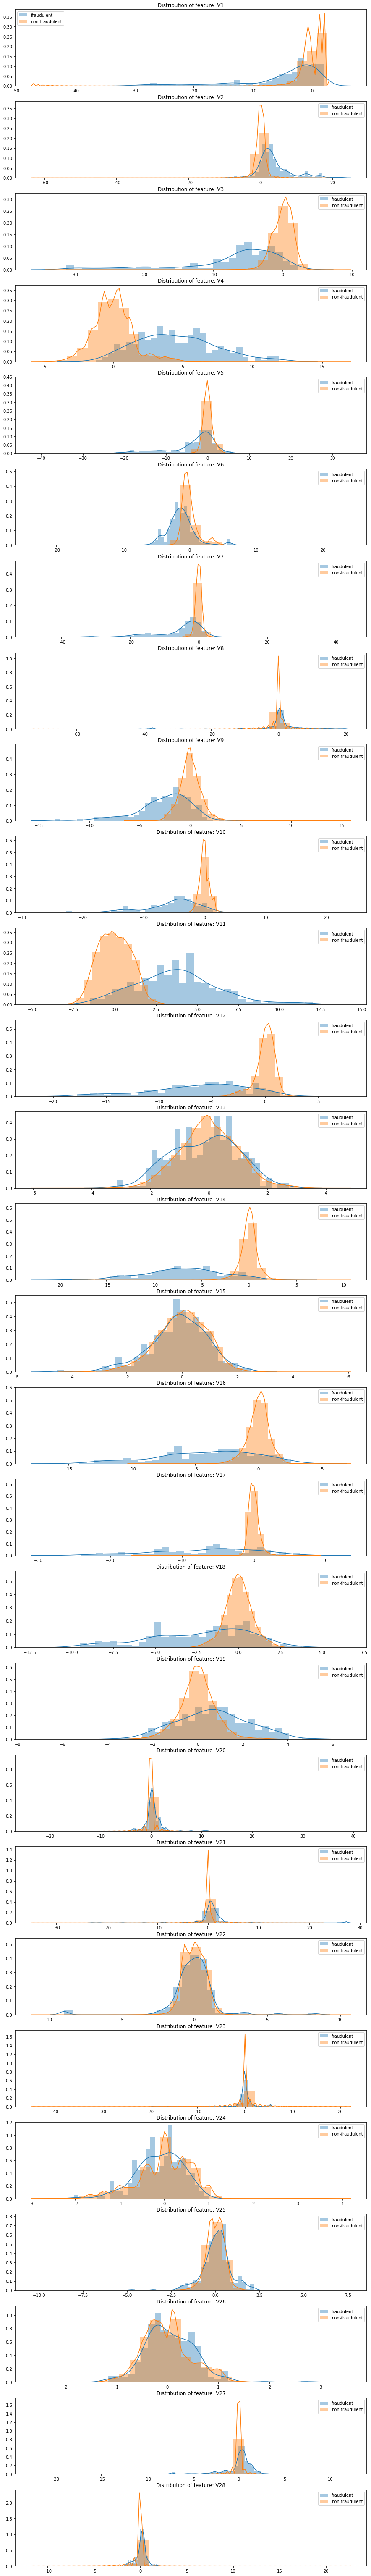

In [79]:
import matplotlib.gridspec as gridspec
import seaborn as sns
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.distplot(X_train[feat][y_train==1], bins=30)
    sns.distplot(X_train[feat][y_train==0],bins=30)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Build an outlier detection model using a Mixture of Gaussians using a subset of features of your choice (pick a few) and a number of mixture components. Report the precision@k for k=1, 10 and 100 (on test data). Repeat this model creation process at least 4 more times, each time selecting different parameters (features selected, number of mixture components), and reporting the precision as above. Organize your findings in a table or plot and describe your findings. What can you conclude about what models work best? [3] **5 features are selected for each model and 1 of the 5 is replaced each time. 2 number of components are tested (2 and 5). Within the 10 trials shown in the 2 tables below, the model with feature data of V1, V2, V3, V4 and V7 and number of components of 5 performs the best. It has a precision of 0.6 and a recall of 0.037 at k=10, a precision of 0.34 and a recall of 0.207. Generally, models with 5 components perform better than that of 2 components.**

In [80]:
# 5 features are selected at first and 1 of the 5 features is replaced everytime for a total of 6 cases.

n=([[1,2,3,4,5], [1,2,3,4,6], [1,2,3,4,7], [1,2,3,4,8], [1,2,3,4,9], [1,2,3,4,10]])

# Create empty lists
k1=[]
k10=[]
k100=[]
c1=[]
c10=[]
c100=[]

for x in ([0,1,2,3,4,5]):
  colname = X_train.columns[n[x]] # retrieve names of selected column
  gm = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0, )
  gm.fit(X_train[colname].values)
  
  p_gm = gm.score_samples(X_test[colname].values)  
  
  for i in [1, 10, 100]: 
    mn_gm = sorted(p_gm)[i] 
    precision = precision_score(y_test, p_gm < mn_gm)
    recall = recall_score(y_test, p_gm < mn_gm) 
    if i==1:     # organize output by k values
      k1.append(precision)
      c1.append(recall)
    elif i==10:
      k10=np.append(k10,precision)
      c10=np.append(c10,recall)
    elif i==100:
      k100=np.append(k100,precision)
      c100=np.append(c100,recall)

# construct the output dataframe

a={'Feature':['V1,V2,V3,V4,V5','V1,V2,V3,V4,V6','V1,V2,V3,V4,V7','V1,V2,V3,V4,V8','V1,V2,V3,V4,V9','V1,V2,V3,V4,V10']}
df=pd.DataFrame(a)
df['N_components']=[5,5,5,5,5,5]
df['P(k=1)']=k1
df['R(k=1)']=c1
df['P(k=10)']=k10
df['R(k=10)']=c10
df['P(k=100)']=k100
df['R(k=100)']=c100

df



,Feature,N_components,P(k=1),R(k=1),P(k=10),R(k=10),P(k=100),R(k=100)
0,"V1,V2,V3,V4,V5",5,0.0,0.0,0.5,0.030488,0.34,0.207317
1,"V1,V2,V3,V4,V6",5,0.0,0.0,0.0,0.000000,0.30,0.182927
2,"V1,V2,V3,V4,V7",5,0.0,0.0,0.6,0.036585,0.34,0.207317
3,"V1,V2,V3,V4,V8",5,0.0,0.0,0.0,0.000000,0.17,0.103659
4,"V1,V2,V3,V4,V9",5,0.0,0.0,0.1,0.006098,0.20,0.121951
5,"V1,V2,V3,V4,V10",5,0.0,0.0,0.0,0.000000,0.17,0.103659


In [81]:
# Repeat the same process with n_components = 2

k1=[]
k10=[]
k100=[]
c1=[]
c10=[]
c100=[]

for x in ([0,1,2,3,4,5]):
  colname = X_train.columns[n[x]] # retrieve names of selected column
  gm = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=0, )
  gm.fit(X_train[colname].values)
  
  p_gm = gm.score_samples(X_test[colname].values)  
  
  for i in [1, 10, 100]: 
    mn_gm = sorted(p_gm)[i] 
    precision = precision_score(y_test, p_gm < mn_gm)
    recall = recall_score(y_test, p_gm < mn_gm) 
    if i==1:     # organize output by k values
      k1.append(precision)
      c1.append(recall)
    elif i==10:
      k10=np.append(k10,precision)
      c10=np.append(c10,recall)
    elif i==100:
      k100=np.append(k100,precision)
      c100=np.append(c100,recall)

a={'Feature':['V1,V2,V3,V4,V5','V1,V2,V3,V4,V6','V1,V2,V3,V4,V7','V1,V2,V3,V4,V8','V1,V2,V3,V4,V9','V1,V2,V3,V4,V10']}
df=pd.DataFrame(a)
df['N_components']=[2,2,2,2,2,2]
df['P(k=1)']=k1
df['R(k=1)']=c1
df['P(k=10)']=k10
df['R(k=10)']=c10
df['P(k=100)']=k100
df['R(k=100)']=c100
df

,Feature,N_components,P(k=1),R(k=1),P(k=10),R(k=10),P(k=100),R(k=100)
0,"V1,V2,V3,V4,V5",2,0.0,0.0,0.1,0.006098,0.19,0.115854
1,"V1,V2,V3,V4,V6",2,0.0,0.0,0.0,0.000000,0.21,0.128049
2,"V1,V2,V3,V4,V7",2,0.0,0.0,0.0,0.000000,0.24,0.146341
3,"V1,V2,V3,V4,V8",2,0.0,0.0,0.1,0.006098,0.14,0.085366
4,"V1,V2,V3,V4,V9",2,0.0,0.0,0.0,0.000000,0.24,0.146341
5,"V1,V2,V3,V4,V10",2,0.0,0.0,0.2,0.012195,0.34,0.207317
